# CS613 Final Project: Image Classification 

In [2]:
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt

## Preprocessing

In [12]:
def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')
    
def load_cifar10():
    train_data, train_labels = [] , []
    for i in range(1,6):
        batch = unpickle(f"./cifar-10-python/cifar-10-batches-py/data_batch_{i}")
        train_data.append(batch[b'data'])
        train_labels.extend(batch[b'labels'])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.array(train_labels)

    # Load test batch
    test_batch = unpickle(f"./cifar-10-python/cifar-10-batches-py/test_batch")
    test_data = np.array(test_batch[b'data'])
    test_labels = np.array(test_batch[b'labels'])

    # Reshape the data to (N, 32, 32, 3)
    train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return train_data, train_labels, test_data, test_labels

# Save data to CSV
def save_to_csv(data, labels, file_path):
    # Combine labels and data
    combined = np.column_stack((labels, data))
    # Save as a CSV file
    np.savetxt(file_path, combined, delimiter=",", fmt="%f")
    print(f"Saved {file_path} successfully!")
    
# Prepare data
def normalize_images(data):
    return data / 255.0

# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size),labels] = 1
    return one_hot

In [13]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
x_train, y_train, x_test, y_test = load_cifar10()

# Preprocess data
print("Preprocessing data...")
x_train = normalize_images(x_train).reshape(x_train.shape[0], -1)
x_test = normalize_images(x_test).reshape(x_test.shape[0],-1)

Loading CIFAR-10 dataset...
Preprocessing data...


In [14]:
# Save csv files if needed
print("Saving to CSV...")
save_to_csv(x_train, y_train, "train.csv")
save_to_csv(x_test, y_test, "test.csv")
print("CSV files created.")

Saving to CSV...
Saved train.csv successfully!
Saved test.csv successfully!
CSV files created.


## Evaluation Functions

In [6]:
# Model Evaluation
def confusion_matrix(y_true, y_pred):
    num_classes = y_true.shape[1]
    cm = np.zeros((num_classes, num_classes), dtype=int)
    y_true_indices = np.argmax(y_true, axis=1)
    
    for t, p in zip(y_true_indices, y_pred):
        cm[t, p] += 1
    
    return cm

def accuracy(y_true, y_pred):
    y_true_label = np.argmax(y_true, axis=1)  #Converting one-hot encoded back to label encoded
    return np.sum(y_true_label == y_pred) / len(y_true_label)


def precision(cm):
    
    precisions = []
    
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        if tp + fp > 0:
            precisions.append(tp / (tp + fp))
        else:
            precisions.append(0)
    return np.mean(precisions)

def recall(cm):
    
    recalls = []
    
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        if tp + fn > 0:
            recalls.append(tp / (tp + fn))
        else:
            recalls.append(0)
    return np.mean(recalls)

def f1_score(cm):
    
    precisions = precision(cm)
    recalls = recall(cm)
    
    if (precisions + recalls) > 0:
        return 2 * (precisions * recalls) / (precisions + recalls) 
    else:
        return 0

## Logistic Regression Implementation

In [9]:
class logistic_regression:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs

        #Weight Initalization
        self.num_features = None
        self.num_classes = None
        self.weights = None

        # Initialize lists for tracking losses
        self.train_losses = []
        self.test_losses = []

    # Logistic Regression Functions
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predict(self, X):
        y_pred = self.softmax(np.dot(X, self.weights))
        return np.argmax(y_pred, axis=1)
    
    def log_loss(self, y, y_pred, epsilon=1e-15):
        return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
    
    def categorical_crossentropy(self, y, y_pred, epsilon=1e-15):
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon) 
        return -np.mean(np.sum(y * np.log(y_pred), axis=1))
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def gradient_descent(self, X, y, weights, lr):
        y_pred = self.softmax(np.dot(X, weights))
        error = y_pred - y
        gradient = np.dot(X.T, error) / len(y)
        return weights - lr * gradient


    def fit(self, X_train, y_train, X_test=None, y_test=None):
        self.num_features = X_train.shape[1]
        self.num_classes = y_train.shape[1]
        self.weights = np.random.randn(self.num_features, self.num_classes)
    
        for epoch in range(self.epochs):
            # Update Weights
            self.weights = self.gradient_descent(X_train, y_train, self.weights, self.learning_rate)

            train_pred = self.softmax(np.dot(X_train, self.weights))
            train_loss = self.categorical_crossentropy(y_train, train_pred)
            self.train_losses.append(train_loss)

            if X_test is not None and y_test is not None:
                test_pred = self.softmax(np.dot(X_test, self.weights))
                test_loss = self.categorical_crossentropy(y_test, test_pred)
                self.test_losses.append(test_loss)
            else:
                test_loss = None

            # if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}/{self.epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

In [15]:
# Convert labels to one-hot encoding
num_classes = 10
y_train = one_hot_encode(y_train, num_classes)
y_test = one_hot_encode(y_test, num_classes)

# Add biases to X
X_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
X_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]

In [16]:
lr = logistic_regression(learning_rate=0.1, epochs=1000)
lr.fit(X_train, y_train, X_test, y_test)

Epoch 1/1000: Train Loss = 24.7734, Test Loss = 24.8922
Epoch 2/1000: Train Loss = 20.5121, Test Loss = 20.5999
Epoch 3/1000: Train Loss = 18.3513, Test Loss = 18.4212
Epoch 4/1000: Train Loss = 17.4198, Test Loss = 17.5589
Epoch 5/1000: Train Loss = 16.5867, Test Loss = 16.6907
Epoch 6/1000: Train Loss = 16.3677, Test Loss = 16.4836
Epoch 7/1000: Train Loss = 16.2152, Test Loss = 16.3227
Epoch 8/1000: Train Loss = 16.0762, Test Loss = 16.1903
Epoch 9/1000: Train Loss = 15.9340, Test Loss = 16.0442
Epoch 10/1000: Train Loss = 15.7986, Test Loss = 15.9101
Epoch 11/1000: Train Loss = 15.6620, Test Loss = 15.7709
Epoch 12/1000: Train Loss = 15.5298, Test Loss = 15.6387
Epoch 13/1000: Train Loss = 15.3981, Test Loss = 15.5048
Epoch 14/1000: Train Loss = 15.2693, Test Loss = 15.3753
Epoch 15/1000: Train Loss = 15.1417, Test Loss = 15.2465
Epoch 16/1000: Train Loss = 15.0169, Test Loss = 15.1213
Epoch 17/1000: Train Loss = 14.8942, Test Loss = 14.9975
Epoch 18/1000: Train Loss = 14.7741, Tes

In [18]:
# Generate predictions for train and test sets
train_pred = lr.predict(X_train)

# Calculate training metrics
train_cm = confusion_matrix(y_train, train_pred)
train_accuracy = accuracy(y_train, train_pred)
train_precision = precision(train_cm)
train_recall = recall(train_cm)
train_f1 = f1_score(train_cm)

# Print Metrics
print("\nTraining Evaluation:")
print("Confusion Matrix:\n", train_cm)
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")


test_pred = lr.predict(X_test)

test_cm = confusion_matrix(y_test, test_pred)
test_accuracy = accuracy(y_test, test_pred)
test_precision = precision(test_cm)
test_recall = recall(test_cm)
test_f1 = f1_score(test_cm)

print("\nValidation Evaluation:")
print("Confusion Matrix:\n", test_cm)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Training Evaluation:
Confusion Matrix:
 [[ 234  518  917   69   95  542   98  658 1717  152]
 [  70 1821  411  126  113  489  199  494  830  447]
 [  59  304 1583   95  208  862  355  809  643   82]
 [  65  539  810  244  198 1310  416  733  520  165]
 [  37  297 1329  103  324  894  485 1116  314  101]
 [  47  399  898  202  177 1645  324  731  479   98]
 [  23  379  982  189  261  993  987  755  290  141]
 [  49  387  834  136  239  719  308 1727  400  201]
 [ 104  639  513   54   54  393   76  352 2599  216]
 [  93 1191  434  107  100  347  214  582 1071  861]]
Accuracy: 0.2405
Precision: 0.2475
Recall: 0.2405
F1 Score: 0.2440

Validation Evaluation:
Confusion Matrix:
 [[ 43  94 178  11  12 111  22 136 368  25]
 [ 17 355  96  16  20  91  45  90 185  85]
 [ 10  55 315  22  42 152  85 174 128  17]
 [  7 107 185  52  36 277  77 136  91  32]
 [  6  57 275  23  59 188  91 216  62  23]
 [ 10  90 207  32  34 317  65 135  83  27]
 [  1  77 192  38  44 191 220 166  49  22]
 [ 11  82 177  33

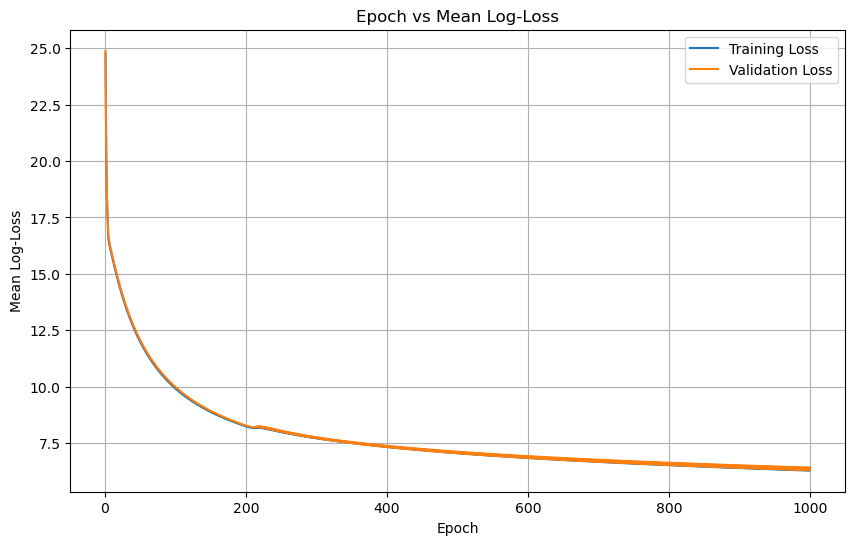

In [19]:
# Plot epoch vs log-loss
epochs = list(range(1, len(lr.train_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, lr.train_losses, label='Training Loss')
plt.plot(epochs, lr.test_losses, label='Validation Loss')

plt.title('Epoch vs Mean Log-Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Log-Loss')
plt.grid(True)
plt.legend()
plt.show()

## SVM Implementation

In [24]:
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_epochs=10):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_epochs = n_epochs
        self.weights = None
        self.accuracy_per_epoch = []

    def fit(self, X, y, num_classes, x_test = None, y_test = None):
        _, n_features = X.shape
        self.weights = np.zeros((num_classes, n_features))

        for epoch in range(self.n_epochs):
            for c in range(num_classes):
                y_binary = np.where(y == c, 1, -1)
                w = self.weights[c,:]
                
                for idx, x_i in enumerate(X):
                    condition = y_binary[idx] * (np.dot(x_i, w)) # Check if current sample passes margin condition
                    if condition >= 1:
                        w -= self.learning_rate * (2 * self.lambda_param * w)
                    else:
                        w -= self.learning_rate * (2 * self.lambda_param * w - x_i * y_binary[idx])
                            
                self.weights[c, :] = w
            
            # Evaluate after each epoch
            if x_test is not None and y_test is not None:
                y_pred = self.predict(x_test)
                accuracy = np.mean(y_pred == y_test)
                self.accuracy_per_epoch.append(accuracy)
                print(f"Epoch {epoch + 1}/{self.n_epochs} - Accuracy: {accuracy * 100:.2f}%")
                         
    def predict(self, X):
        linear_output = np.dot(X, self.weights.T)
        return np.argmax(linear_output, axis=1)

In [32]:
# Start timer
start_time = time.time()

# Train the SVM
print("Training SVM...")
svm = SVM(learning_rate=1e-6, lambda_param=0.01, n_epochs=100)

# Decode labels from one-hot encoding to integers
y_train_decoded = np.argmax(y_train, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)

# Fit the SVM model
svm.fit(X_train, y_train_decoded, num_classes, x_test=X_test, y_test=y_test_decoded)

# End timer and print elapsed time
elapsed_time = time.time() - start_time
print(f"Total runtime: {elapsed_time:.2f} seconds")

Training SVM...
Epoch 1/100 - Accuracy: 25.69%
Epoch 2/100 - Accuracy: 29.49%
Epoch 3/100 - Accuracy: 31.20%
Epoch 4/100 - Accuracy: 32.18%
Epoch 5/100 - Accuracy: 32.86%
Epoch 6/100 - Accuracy: 33.52%
Epoch 7/100 - Accuracy: 33.91%
Epoch 8/100 - Accuracy: 34.37%
Epoch 9/100 - Accuracy: 34.57%
Epoch 10/100 - Accuracy: 34.92%
Epoch 11/100 - Accuracy: 35.05%
Epoch 12/100 - Accuracy: 35.14%
Epoch 13/100 - Accuracy: 35.47%
Epoch 14/100 - Accuracy: 35.42%
Epoch 15/100 - Accuracy: 35.70%
Epoch 16/100 - Accuracy: 35.84%
Epoch 17/100 - Accuracy: 36.08%
Epoch 18/100 - Accuracy: 36.38%
Epoch 19/100 - Accuracy: 36.44%
Epoch 20/100 - Accuracy: 36.48%
Epoch 21/100 - Accuracy: 36.44%
Epoch 22/100 - Accuracy: 36.51%
Epoch 23/100 - Accuracy: 36.58%
Epoch 24/100 - Accuracy: 36.68%
Epoch 25/100 - Accuracy: 36.78%
Epoch 26/100 - Accuracy: 36.91%
Epoch 27/100 - Accuracy: 36.93%
Epoch 28/100 - Accuracy: 37.10%
Epoch 29/100 - Accuracy: 37.20%
Epoch 30/100 - Accuracy: 37.31%
Epoch 31/100 - Accuracy: 37.36%
E

In [33]:
# Evaluate the model
print("Evaluating SVM...")
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

# Training Metrics
train_cm_svm = confusion_matrix(y_train, y_pred_train)
train_accuracy_svm = accuracy(y_train, y_pred_train)
train_precision_svm = precision(train_cm_svm)
train_recall_svm = recall(train_cm_svm)
train_f1_svm = f1_score(train_cm_svm)

print("\nSVM Training Evaluation:")
print("Confusion Matrix:\n", train_cm_svm)
print(f"Accuracy: {train_accuracy_svm:.4f}")
print(f"Precision: {train_precision_svm:.4f}")
print(f"Recall: {train_recall_svm:.4f}")
print(f"F1 Score: {train_f1_svm:.4f}")

# Test Metrics
test_cm_svm = confusion_matrix(y_test, y_pred_test)
test_accuracy_svm = accuracy(y_test, y_pred_test)
test_precision_svm = precision(test_cm_svm)
test_recall_svm = recall(test_cm_svm)
test_f1_svm = f1_score(test_cm_svm)

print("\nSVM Validation Evaluation:")
print("Confusion Matrix:\n", test_cm_svm)
print(f"Accuracy: {test_accuracy_svm:.4f}")
print(f"Precision: {test_precision_svm:.4f}")
print(f"Recall: {test_recall_svm:.4f}")
print(f"F1 Score: {test_f1_svm:.4f}")

Evaluating SVM...

SVM Training Evaluation:
Confusion Matrix:
 [[2381  325   53  185   52  194  130  302  926  452]
 [ 300 2575   27  130   58  197  219  200  438  856]
 [ 703  283  662  499  423  610  836  511  303  170]
 [ 326  407  138 1359  122 1093  610  286  312  347]
 [ 426  196  306  346 1199  532  930  658  197  210]
 [ 214  307  227  821  187 1938  515  357  262  172]
 [ 132  287  123  638  318  470 2479  209  140  204]
 [ 240  327  110  341  343  451  276 2241  204  467]
 [ 808  441   22  101   21  218   59  109 2687  534]
 [ 287  918   25  110   34  156  181  198  502 2589]]
Accuracy: 0.4022
Precision: 0.4011
Recall: 0.4022
F1 Score: 0.4017

SVM Validation Evaluation:
Confusion Matrix:
 [[498  66  15  40  12  34  25  48 174  88]
 [ 62 497   6  29   8  43  40  42 107 166]
 [148  54 123 123  88 108 178  92  59  27]
 [ 65  80  38 255  25 229 111  62  52  83]
 [ 73  37  67  77 216 105 211 142  42  30]
 [ 48  57  48 164  42 369  93  86  64  29]
 [ 20  55  31 128  57  79 522  38 

## Ensemble Model